In [1]:
#Импортируем необходимые модули
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from catboost import CatBoostClassifier

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.shape, test_df.shape

((8693, 14), (4277, 13))

In [4]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


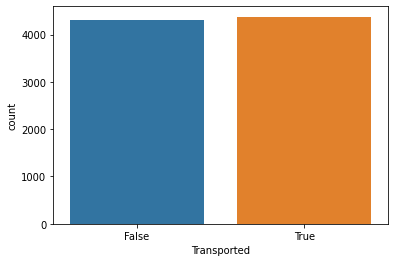

In [5]:
sns.countplot(x=train_df.Transported);

Классы сбалансированы, следовательно, в качестве меры качества прогнозирования можем использовать accuracy

In [6]:
train_df.describe(include='all')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
count,8693,8492,8476,8494,8511,8514.000000,8490,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8493,8693
unique,8693,3,2,6560,3,NaN,2,NaN,NaN,NaN,NaN,NaN,8473,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,NaN,False,NaN,NaN,NaN,NaN,NaN,Gollux Reedall,True
freq,1,4602,5439,8,5915,NaN,8291,NaN,NaN,NaN,NaN,NaN,2,4378
mean,NaN,NaN,NaN,NaN,NaN,28.827930,NaN,224.687617,458.077203,173.729169,311.138778,304.854791,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,14.489021,NaN,666.717663,1611.489240,604.696458,1136.705535,1145.717189,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,19.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,27.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,38.000000,NaN,47.000000,76.000000,27.000000,59.000000,46.000000,NaN,NaN


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [9]:
train_df = train_df.drop('Name', axis=1)
test_df = test_df.drop('Name', axis=1)

In [10]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


# Работа с пропущенными значениями

In [11]:
train_df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64

In [12]:
test_df.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
dtype: int64

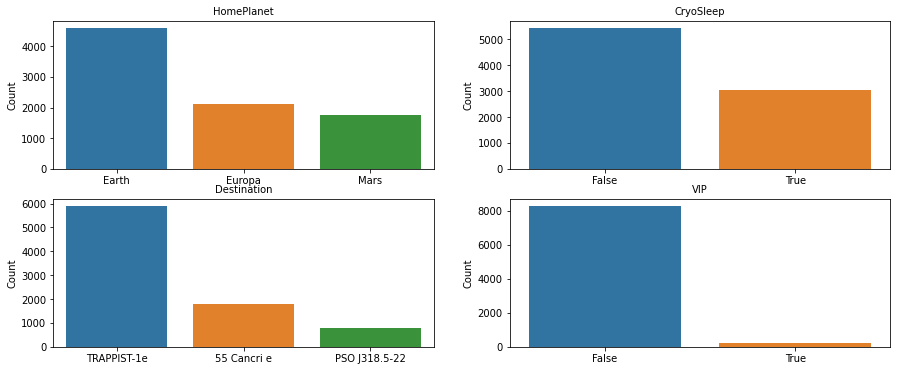

In [13]:
ig, myplot = plt.subplots(figsize = (15,6), nrows = 2,ncols = 2)

features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

row, col, num_cols = 0,0,2

for u in features:
    sns.barplot(x = train_df[u].value_counts().index,y = train_df[u].value_counts(),
                ax  = myplot[row, col])
    myplot[row, col].set_xlabel("")
    myplot[row, col].set_title(u, fontsize = 10)
    myplot[row, col].set_ylabel("Count")
    col = col + 1
    if col == 2:
        col = 0
        row = row + 1

### Age

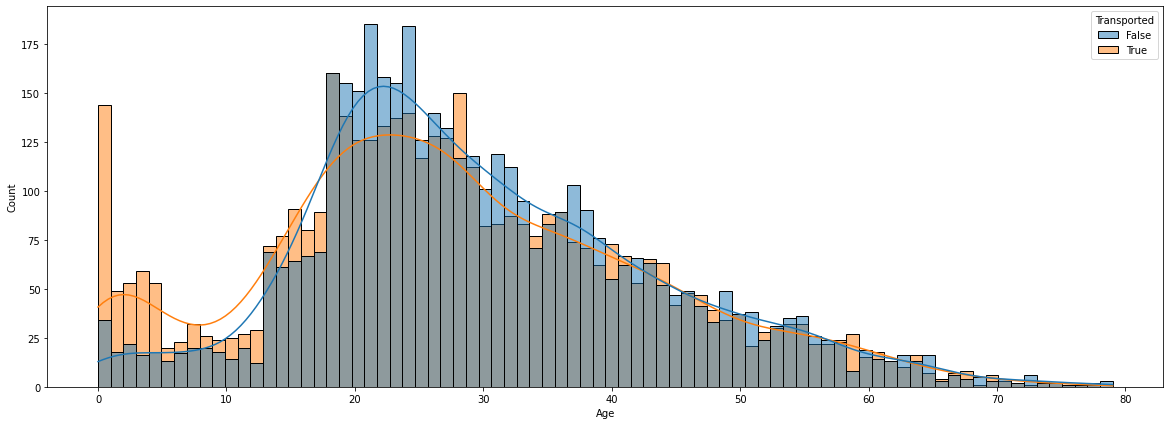

In [14]:
plt.figure(figsize=(20, 7))
sns.histplot(x='Age', hue='Transported', data=train_df, kde=True, bins=80);

In [15]:
train_df.groupby(train_df.Age.isna()).Transported.value_counts(normalize=True)

Age    Transported
False  True           0.503641
       False          0.496359
True   True           0.502793
       False          0.497207
Name: Transported, dtype: float64

In [16]:
train_df.groupby(train_df.Transported).agg({'Age': 'mean'})

,Age
Transported,
False,29.922858
True,27.748834


Мы видим, что вне зависимости от того, вставлено значение возраста или нет, значение колонки Transported в среднем равно, следовательно, возраст практически никак не влияет на целевую переменную. Заменим пропуски средним значением.

In [17]:
train_df.Age = train_df.Age.fillna(train_df.Age.mean().round(2))
test_df.Age = test_df.Age.fillna(train_df.Age.mean().round(2))

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8693 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(6)
memory usage: 823.6+ KB


### Суммарные траты на дополнительные услуги

Для того, чтобы однозначно определять богатых пассажиров от бедных имеет смылс рассчитаывать суммарные расходы на дополнительные услуги (Это признаки RoomService, FoodCourt, ShoppingMall, Spa, VRDeck). 

In [19]:
train_df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = train_df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0)
train_df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = test_df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0)

In [20]:
train_df['SumWastes'] = train_df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
test_df['SumWastes'] = test_df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

In [21]:
train_df = train_df.drop(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], axis=1)
test_df = test_df.drop(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], axis=1)

In [22]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,Transported,SumWastes
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,False,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,True,2832.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,False,0.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,False,7418.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,True,645.0


### HomePlanet

In [23]:
train_df.groupby('HomePlanet').Transported.mean()

HomePlanet
Earth     0.423946
Europa    0.658846
Mars      0.523024
Name: Transported, dtype: float64

Видим, что есть различия в частоте выживаемости между пассажирами с разных планет. Есть предположение о том, что жителей разных планет селили на разные палубы, стоит это проверить. Для этого создадим отдельные колонки для палубы и той стороны, на которой расположена каюта.

In [24]:
train_df['Deck'] = train_df.Cabin.apply(lambda x: x.split(sep='/')[0] if pd.notnull(x) else x)
train_df['Side'] = train_df.Cabin.apply(lambda x: x.split(sep='/')[2] if pd.notnull(x) else x)

test_df['Deck'] = test_df.Cabin.apply(lambda x: x.split(sep='/')[0] if pd.notnull(x) else x)
test_df['Side'] = test_df.Cabin.apply(lambda x: x.split(sep='/')[2] if pd.notnull(x) else x)

In [25]:
train_df = train_df.drop('Cabin', axis=1)
test_df = test_df.drop('Cabin', axis=1)

In [26]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,Transported,SumWastes,Deck,Side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,False,0.0,B,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,True,2832.0,F,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,False,0.0,A,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,False,7418.0,A,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,True,645.0,F,S


In [27]:
train_df.groupby(['HomePlanet', 'Deck']).Transported.count()

HomePlanet  Deck
Earth       E        395
            F       1614
            G       2498
Europa      A        252
            B        766
            C        734
            D        186
            E        128
            T          4
Mars        D        282
            E        330
            F       1110
Name: Transported, dtype: int64

Видим, что жителей Европы преимущественно селили на разных палубах. Нам важно именно расположение пассажиров на борту, а не откуда они. Следовательно, в будущем можем удалить информацию о признаке HomePlanet.

In [28]:
train_df.groupby('Deck').agg({'Transported': ['mean', 'count']})

Transported      
            mean count
Deck                  
A       0.496094   256
B       0.734275   779
C       0.680054   747
D       0.433054   478
E       0.357306   876
F       0.439871  2794
G       0.516217  2559
T       0.200000     5

Видим, что для платформ с самым большим количеством пассажиров вижимаемость примерно одинакова и колеблется около 50%. Заменим пропущенные значения на медианное значение.

In [29]:
train_df.Deck = train_df.Deck.fillna(train_df.Deck.mode()[0])
test_df.Deck = test_df.Deck.fillna(test_df.Deck.mode()[0])

In [30]:
train_df.groupby('Side').agg({'Transported': ['mean', 'count']})

Transported      
            mean count
Side                  
P       0.451260  4206
S       0.555037  4288

Прмиерно те же рассуждения применимы для Side. Заменим пропущенные значения на моду.

In [31]:
train_df.Side = train_df.Side.fillna(train_df.Side.mode()[0])
test_df.Side = test_df.Side.fillna(test_df.Side.mode()[0])

Теперь можем удалить информацию о HomePlanet.

In [32]:
train_df = train_df.drop('HomePlanet', axis = 1)
test_df = test_df.drop('HomePlanet', axis = 1)

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  8693 non-null   object 
 1   CryoSleep    8476 non-null   object 
 2   Destination  8511 non-null   object 
 3   Age          8693 non-null   float64
 4   VIP          8490 non-null   object 
 5   Transported  8693 non-null   bool   
 6   SumWastes    8693 non-null   float64
 7   Deck         8693 non-null   object 
 8   Side         8693 non-null   object 
dtypes: bool(1), float64(2), object(6)
memory usage: 551.9+ KB


In [34]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  4277 non-null   object 
 1   CryoSleep    4184 non-null   object 
 2   Destination  4185 non-null   object 
 3   Age          4277 non-null   float64
 4   VIP          4184 non-null   object 
 5   SumWastes    4277 non-null   float64
 6   Deck         4277 non-null   object 
 7   Side         4277 non-null   object 
dtypes: float64(2), object(6)
memory usage: 267.4+ KB


### CryoSleep

In [35]:
train_df.groupby(['Deck', 'CryoSleep']).agg({'Transported':  'count'})

Transported
Deck CryoSleep             
A    False              182
     True                68
B    False              341
     True               419
C    False              430
     True               294
D    False              364
     True               104
E    False              688
     True               168
F    False             2284
     True               634
G    False             1146
     True              1350
T    False                4

In [36]:
cryosleep_fill = [False, True, False, False, False, False, True, False]

i = 0
for deck in train_df.Deck.unique():
    train_df.loc[(train_df.CryoSleep.isna()) & (train_df.Deck == deck), 'CryoSleep'] = cryosleep_fill[i]
    test_df.loc[(test_df.CryoSleep.isna()) & (test_df.Deck == deck), 'CryoSleep'] = cryosleep_fill[i]
    
    i += 1

In [37]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  8693 non-null   object 
 1   CryoSleep    8693 non-null   object 
 2   Destination  8511 non-null   object 
 3   Age          8693 non-null   float64
 4   VIP          8490 non-null   object 
 5   Transported  8693 non-null   bool   
 6   SumWastes    8693 non-null   float64
 7   Deck         8693 non-null   object 
 8   Side         8693 non-null   object 
dtypes: bool(1), float64(2), object(6)
memory usage: 551.9+ KB


### Destination

In [38]:
train_df.Destination.value_counts()

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

In [39]:
train_df.groupby('Destination').Transported.mean()

Destination
55 Cancri e      0.610000
PSO J318.5-22    0.503769
TRAPPIST-1e      0.471175
Name: Transported, dtype: float64

In [40]:
train_df.Destination = train_df.Destination.fillna('TRAPPIST-1e')
test_df.Destination = test_df.Destination.fillna('TRAPPIST-1e')

In [41]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  8693 non-null   object 
 1   CryoSleep    8693 non-null   object 
 2   Destination  8693 non-null   object 
 3   Age          8693 non-null   float64
 4   VIP          8490 non-null   object 
 5   Transported  8693 non-null   bool   
 6   SumWastes    8693 non-null   float64
 7   Deck         8693 non-null   object 
 8   Side         8693 non-null   object 
dtypes: bool(1), float64(2), object(6)
memory usage: 551.9+ KB


### VIP

In [42]:
train_df.VIP.value_counts()

False    8291
True      199
Name: VIP, dtype: int64

In [43]:
train_df.groupby('VIP').Transported.mean()

VIP
False    0.506332
True     0.381910
Name: Transported, dtype: float64

In [44]:
train_df.VIP = train_df.VIP.fillna(False)
test_df.VIP = test_df.VIP.fillna(False)

In [45]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  8693 non-null   object 
 1   CryoSleep    8693 non-null   object 
 2   Destination  8693 non-null   object 
 3   Age          8693 non-null   float64
 4   VIP          8693 non-null   bool   
 5   Transported  8693 non-null   bool   
 6   SumWastes    8693 non-null   float64
 7   Deck         8693 non-null   object 
 8   Side         8693 non-null   object 
dtypes: bool(2), float64(2), object(5)
memory usage: 492.5+ KB


In [46]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  4277 non-null   object 
 1   CryoSleep    4277 non-null   object 
 2   Destination  4277 non-null   object 
 3   Age          4277 non-null   float64
 4   VIP          4277 non-null   bool   
 5   SumWastes    4277 non-null   float64
 6   Deck         4277 non-null   object 
 7   Side         4277 non-null   object 
dtypes: bool(1), float64(2), object(5)
memory usage: 238.2+ KB


Мы избавились от пропущенных значений, теперь мы можем приступить обработке признаков

# Обработка признаков

In [47]:
# Определим группу, в которой находился пассажир
train_df['Group'] = train_df.PassengerId.apply(lambda x: int(x.split(sep='_')[0]))
test_df['Group'] = test_df.PassengerId.apply(lambda x: int(x.split(sep='_')[0]))

In [48]:
# Сам номер группы не несет в себе никакой информации, нам важно, из скольких человек состояла группа у каждого пассажира.
train_df = \
train_df.merge(train_df.groupby('Group').Transported.count(), on='Group', how='inner').\
drop('Group', axis=1).rename({'Transported_y': 'Group'}, axis=1)

In [49]:
test_df = \
test_df.merge(test_df.groupby('Group').Age.count(), on='Group', how='inner').\
drop('Group', axis=1).rename({'Age_y': 'Group'}, axis=1)

In [50]:
train_df = train_df.drop('PassengerId', axis=1)

In [51]:
test_df = test_df.drop('PassengerId', axis=1)

In [52]:
train_df = train_df.rename({'Transported_x': 'target'}, axis=1) # Переименовали целевую переменную в target

In [53]:
# Призаки CryoSleep, VIP и target представим в бинарном виде (1 или 0)
train_df[['CryoSleep', 'VIP', 'target']] = train_df[['CryoSleep', 'VIP', 'target']].astype(int)
test_df[['CryoSleep', 'VIP']] = test_df[['CryoSleep', 'VIP']].astype(int)

Закодируем категориальные признаки 'Destination', 'Deck', 'Side' при помощи one-hot-encoding.

In [54]:
train_df = train_df.join(pd.get_dummies(train_df[['Destination', 'Deck', 'Side']]))
test_df = test_df.join(pd.get_dummies(test_df[['Destination', 'Deck', 'Side']]))


In [55]:
train_df = train_df.drop(['Destination', 'Deck', 'Side'], axis=1)
test_df = test_df.drop(['Destination', 'Deck', 'Side'], axis=1)

In [56]:
# Убедимся, что все в порядке с размерностями и мы ничего не потеряли
train_df.shape, test_df.shape

((8693, 19), (4277, 18))

In [57]:
train_df.head()

,CryoSleep,Age,VIP,target,SumWastes,Group,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,0,39.0,0,0,0.0,1,0,0,1,0,1,0,0,0,0,0,0,1,0
1,0,24.0,0,1,2832.0,1,0,0,1,0,0,0,0,0,1,0,0,0,1
2,0,58.0,1,0,0.0,2,0,0,1,1,0,0,0,0,0,0,0,0,1
3,0,33.0,0,0,7418.0,2,0,0,1,1,0,0,0,0,0,0,0,0,1
4,0,16.0,0,1,645.0,1,0,0,1,0,0,0,0,0,1,0,0,0,1


In [58]:
test_df = test_df.rename({'Age_x': 'Age'}, axis=1)

## Обработка выбросов

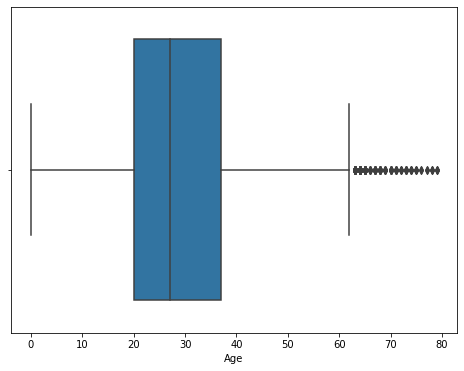

In [59]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=train_df, x='Age');

Будем представлять возраст пассажира, как его принадлежность к определенной возрастной группе, каждая по 10 лет, а также старики в отдельной группе.

In [60]:
cut_bins = list(range(-1, 62, 10)) + [80]
train_df['AgeGroup'] = pd.cut(train_df.Age, bins=cut_bins, labels=False)
test_df['AgeGroup'] = pd.cut(test_df.Age, bins=cut_bins, labels=False)


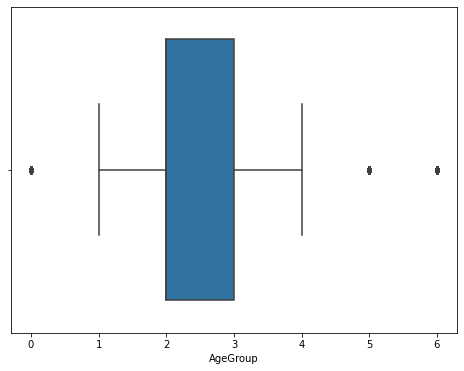

In [61]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=train_df, x='AgeGroup');

Теперь можем удалить колонку Age, возраст будет представлять, как принадлежность к группе.

In [62]:
train_df = train_df.drop('Age', axis = 1)
test_df = test_df.drop('Age', axis = 1)

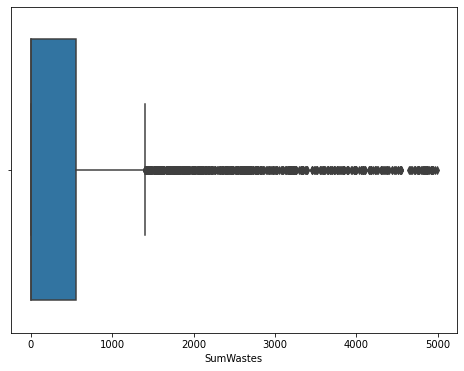

In [63]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=train_df[train_df.SumWastes < 5000] , x = 'SumWastes');

In [64]:
cut_bins = list(range(-1, 1002, 20)) + [34000]
train_df['WasteGroup'] = pd.cut(train_df.SumWastes, bins=cut_bins, labels=False)
test_df['WasteGroup'] = pd.cut(test_df.SumWastes, bins=cut_bins, labels=False)


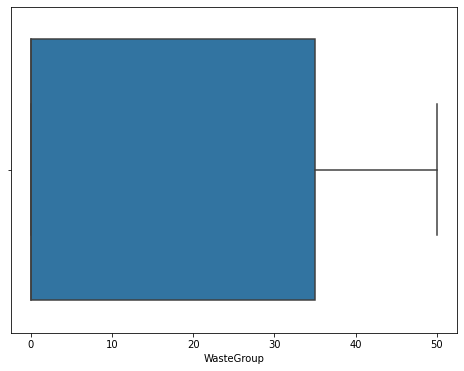

In [65]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=train_df , x = 'WasteGroup');

In [66]:
train_df = train_df.drop('SumWastes', axis = 1)
test_df = test_df.drop('SumWastes', axis = 1)

## Нормализация данных

In [67]:
train_df_norm = (train_df - train_df.mean()) / train_df.std()
test_df_norm = (test_df - test_df.mean()) / test_df.std()

In [68]:
train_df_norm.head()

,CryoSleep,VIP,target,Group,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S,AgeGroup,WasteGroup
0,-0.750991,-0.153054,-1.007216,-0.648697,-0.510984,-0.317468,0.652483,-0.174181,3.187163,-0.306592,-0.241204,-0.33474,-0.724588,-0.64586,-0.023988,1.032805,-1.032805,0.404714,-0.615959
1,-0.750991,-0.153054,0.992722,-0.648697,-0.510984,-0.317468,0.652483,-0.174181,-0.313723,-0.306592,-0.241204,-0.33474,1.379936,-0.64586,-0.023988,-0.968125,0.968125,-0.297237,1.810771
2,-0.750991,6.532879,-1.007216,-0.022267,-0.510984,-0.317468,0.652483,5.740491,-0.313723,-0.306592,-0.241204,-0.33474,-0.724588,-0.64586,-0.023988,-0.968125,0.968125,1.808616,-0.615959
3,-0.750991,-0.153054,-1.007216,-0.022267,-0.510984,-0.317468,0.652483,5.740491,-0.313723,-0.306592,-0.241204,-0.33474,-0.724588,-0.64586,-0.023988,-0.968125,0.968125,0.404714,1.810771
4,-0.750991,-0.153054,0.992722,-0.648697,-0.510984,-0.317468,0.652483,-0.174181,-0.313723,-0.306592,-0.241204,-0.33474,1.379936,-0.64586,-0.023988,-0.968125,0.968125,-0.999188,0.937148


In [69]:
test_df_norm.head()

,CryoSleep,VIP,Group,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S,AgeGroup,WasteGroup
0,1.303083,-0.132674,-0.648897,-0.494676,-0.315825,0.634918,-0.153118,-0.304045,-0.300822,-0.24487,-0.341589,-0.751923,1.580954,-0.037477,-0.974718,0.974718,-0.290527,-1.125930
1,-0.767231,-0.132674,-0.648897,-0.494676,-0.315825,0.634918,-0.153118,-0.304045,-0.300822,-0.24487,-0.341589,1.329613,-0.632382,-0.037477,-0.974718,0.974718,-1.004244,1.056552
2,1.303083,-0.132674,-0.648897,2.021053,-0.315825,-1.574638,-0.153118,-0.304045,3.323448,-0.24487,-0.341589,-0.751923,-0.632382,-0.037477,-0.974718,0.974718,0.423191,-1.125930
3,-0.767231,-0.132674,-0.648897,-0.494676,-0.315825,0.634918,-0.153118,-0.304045,3.323448,-0.24487,-0.341589,-0.751923,-0.632382,-0.037477,-0.974718,0.974718,0.423191,1.056552
4,-0.767231,-0.132674,-0.648897,-0.494676,-0.315825,0.634918,-0.153118,-0.304045,-0.300822,-0.24487,-0.341589,1.329613,-0.632382,-0.037477,-0.974718,0.974718,-0.290527,0.270858


# Визуализация данных

## PCA

In [70]:
pca = PCA(n_components=2)
train_df_pca = pca.fit_transform(train_df.drop('target', axis=1))

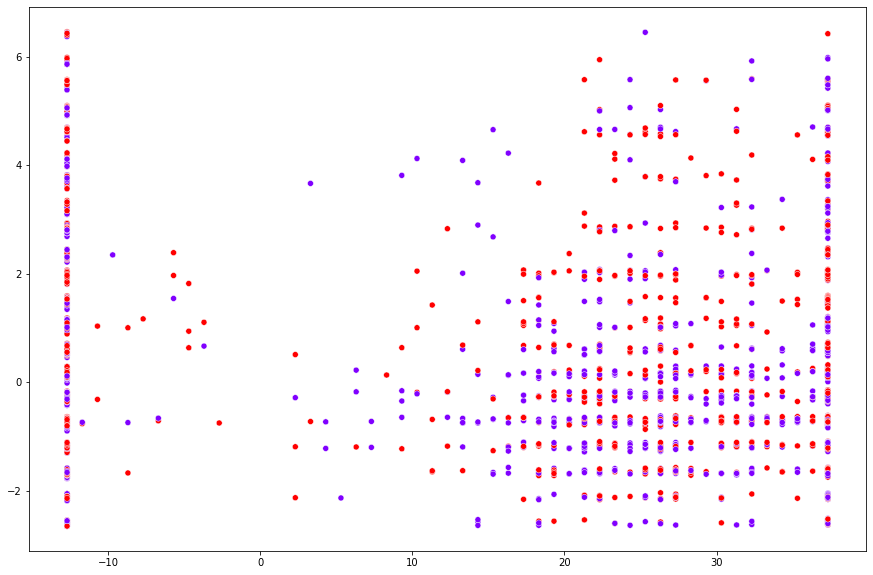

In [71]:
plt.figure(figsize=(15, 10))
sns.scatterplot(x=train_df_pca[:, 0], y=train_df_pca[:, 1], c=train_df.target, cmap='rainbow');

In [72]:
pca.explained_variance_ratio_

array([0.98479986, 0.00641538])

## t-SNE

In [73]:
tsne = TSNE(n_components=2, perplexity=30.0)

In [74]:
train_df_tsne = tsne.fit_transform(train_df.drop('target', axis=1))

C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


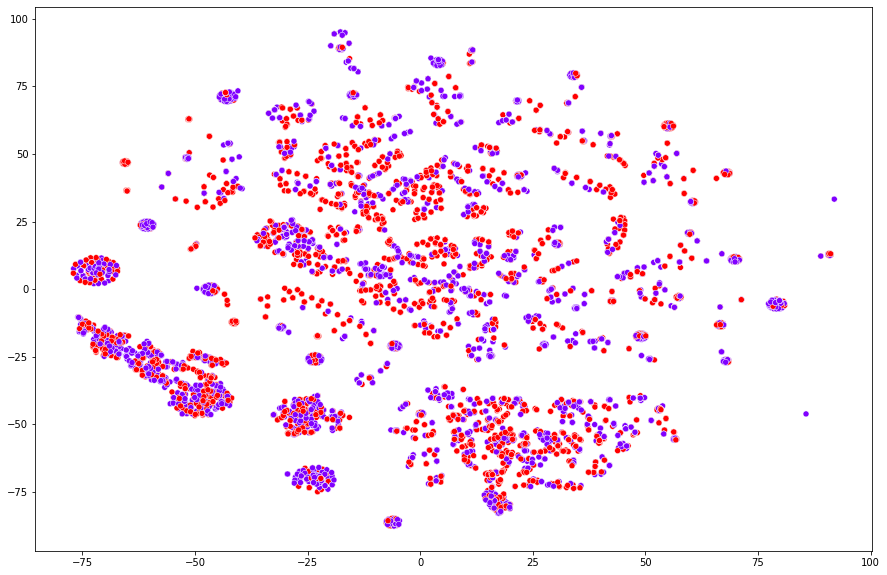

In [75]:
plt.figure(figsize=(15, 10))
sns.scatterplot(x=train_df_tsne[:, 0], y=train_df_tsne[:, 1], c=train_df.target, cmap='rainbow');

Визуализация не дала каких-либо внятных представлений о наших данных, точки расположены довольно хаотично, классы перемешаны.

# Классификация

In [76]:
#Разделим исходную выборку на тестовую и валидационную
X_train, X_test, y_train, y_test = train_test_split(train_df.drop('target', axis=1),
                                                    train_df.target,
                                                    test_size=0.33,
                                                    random_state=42)

## Logistic Regression

In [77]:
regr_clf = LogisticRegression()

In [78]:
distributions = dict(C=uniform(loc=0, scale=4))

In [79]:
regr_rand_cv = RandomizedSearchCV(regr_clf, distributions, random_state=0)

In [80]:
regr_rand_cv.fit(X_train, y_train)

C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

RandomizedSearchCV(estimator=LogisticRegression(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020CE9AA6B30>},
                   random_state=0)

In [81]:
regr_rand_cv.best_params_

{'C': 2.195254015709299}

In [82]:
regr_grid_cv = GridSearchCV(regr_clf, {'C': np.linspace(2.0, 2.5, 10)})

In [83]:
regr_grid_cv.fit(X_train, y_train)

C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': array([2.        , 2.05555556, 2.11111111, 2.16666667, 2.22222222,
       2.27777778, 2.33333333, 2.38888889, 2.44444444, 2.5       ])})

In [84]:
regr_grid_cv.best_params_

{'C': 2.0555555555555554}

In [85]:
best_regr = regr_grid_cv.best_estimator_

In [86]:
y_pred = best_regr.predict(X_test)

In [87]:
print(f"""Regression scores:

Accuracy: {round(accuracy_score(y_test, y_pred), 3)}
Precision: {round(precision_score(y_test, y_pred), 3)}
Recall: {round(recall_score(y_test, y_pred), 3)}
F1 мера: {round(f1_score(y_test, y_pred), 3)}
""")

Regression scores:

Accuracy: 0.714
Precision: 0.753
Recall: 0.644
F1 мера: 0.694



In [88]:
probs = best_regr.predict_proba(X_test)
preds = probs[:,1]

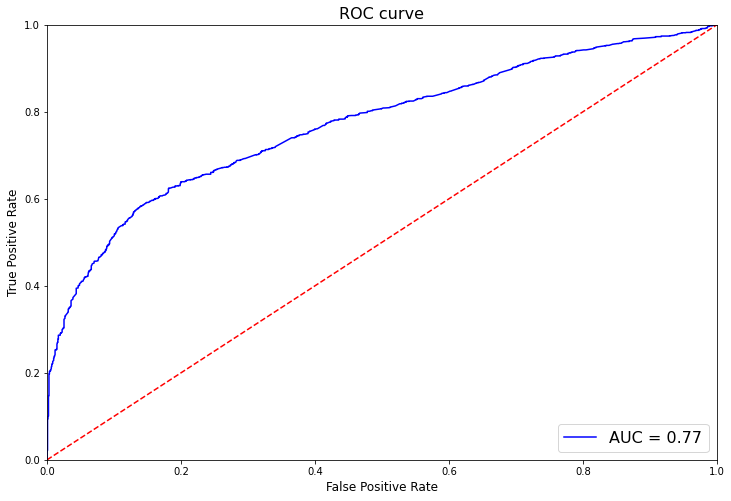

In [89]:
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 8))
plt.title('ROC curve', fontsize=16)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right', fontsize=16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate',fontsize=12)
plt.xlabel('False Positive Rate', fontsize=12)
plt.show()


## KNN

In [90]:
knn = KNeighborsClassifier()

In [91]:
knn_params = {'n_neighbors': range(10, 50, 3), 'weights': ['uniform', 'distance']}
knn_grid = GridSearchCV(knn, knn_params)

knn_grid.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(10, 50, 3),
                         'weights': ['uniform', 'distance']})

In [92]:
knn_grid.best_params_

{'n_neighbors': 25, 'weights': 'uniform'}

In [93]:
best_knn = knn_grid.best_estimator_

In [94]:
y_pred = best_knn.predict(X_test)

In [95]:
print(f"""K Nearest Neighbors scores:

Accuracy: {round(accuracy_score(y_test, y_pred), 3)}
Precision: {round(precision_score(y_test, y_pred), 3)}
Recall: {round(recall_score(y_test, y_pred), 3)}
F1 мера: {round(f1_score(y_test, y_pred), 3)}
""")

K Nearest Neighbors scores:

Accuracy: 0.695
Precision: 0.742
Recall: 0.606
F1 мера: 0.667



In [96]:
probs = best_knn.predict_proba(X_test)
preds = probs[:,1]

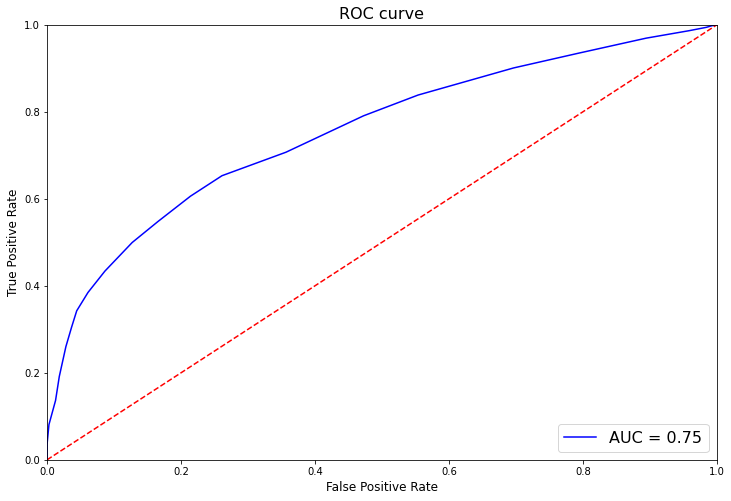

In [97]:
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 8))
plt.title('ROC curve', fontsize=16)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right', fontsize=16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate',fontsize=12)
plt.xlabel('False Positive Rate', fontsize=12)
plt.show()

## Decision Tree

In [98]:
tree = DecisionTreeClassifier()

In [99]:
tree_params = {'max_depth': range(5, 20), 'min_samples_leaf': range(0, 200, 20), 'criterion': ['gini', 'entophy']}
tree_grid = GridSearchCV(tree, tree_params)

tree_grid.fit(X_train, y_train)

C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
825 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.p

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entophy'],
                         'max_depth': range(5, 20),
                         'min_samples_leaf': range(0, 200, 20)})

In [100]:
tree_grid.best_params_

{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 60}

In [101]:
best_tree = tree_grid.best_estimator_

In [102]:
y_pred = best_tree.predict(X_test)

In [103]:
print(f"""Decision Tree scores:

Accuracy: {round(accuracy_score(y_test, y_pred), 3)}
Precision: {round(precision_score(y_test, y_pred), 3)}
Recall: {round(recall_score(y_test, y_pred), 3)}
F1 мера: {round(f1_score(y_test, y_pred), 3)}
""")

Decision Tree scores:

Accuracy: 0.732
Precision: 0.772
Recall: 0.664
F1 мера: 0.714



In [104]:
probs = best_tree.predict_proba(X_test)
preds = probs[:,1]

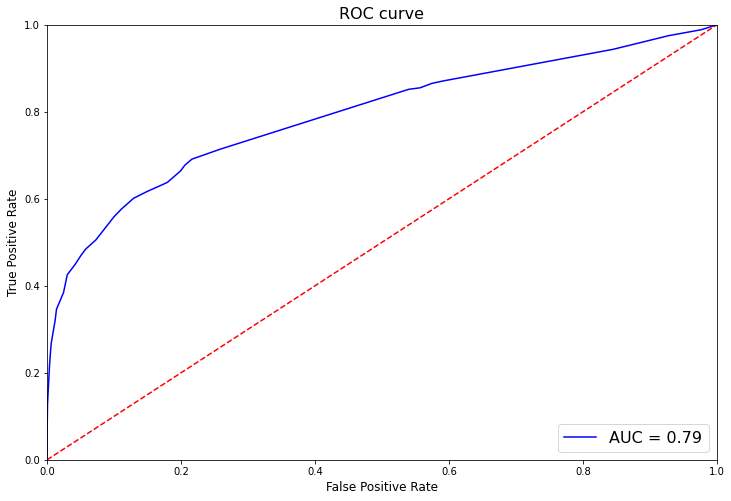

In [105]:
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 8))
plt.title('ROC curve', fontsize=16)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right', fontsize=16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate',fontsize=12)
plt.xlabel('False Positive Rate', fontsize=12)
plt.show()

## Random Forest

In [106]:
forest = RandomForestClassifier()

In [107]:
forest_params = {'max_depth': range(1, 10, 2), 'n_estimators': range(150, 350, 10)}

In [108]:
forest_grid = GridSearchCV(forest, forest_params, n_jobs=-1)

forest_grid.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(1, 10, 2),
                         'n_estimators': range(150, 350, 10)})

In [109]:
forest_grid.best_params_

{'max_depth': 7, 'n_estimators': 260}

In [110]:
best_forest = forest_grid.best_estimator_

y_pred = best_forest.predict(X_test)

In [111]:
print(f"""Random Forest scores:

Accuracy: {round(accuracy_score(y_test, y_pred), 3)}
Precision: {round(precision_score(y_test, y_pred), 3)}
Recall: {round(recall_score(y_test, y_pred), 3)}
F1 мера: {round(f1_score(y_test, y_pred), 3)}
""")

Random Forest scores:

Accuracy: 0.738
Precision: 0.774
Recall: 0.676
F1 мера: 0.722



In [112]:
probs = best_tree.predict_proba(X_test)
preds = probs[:,1]

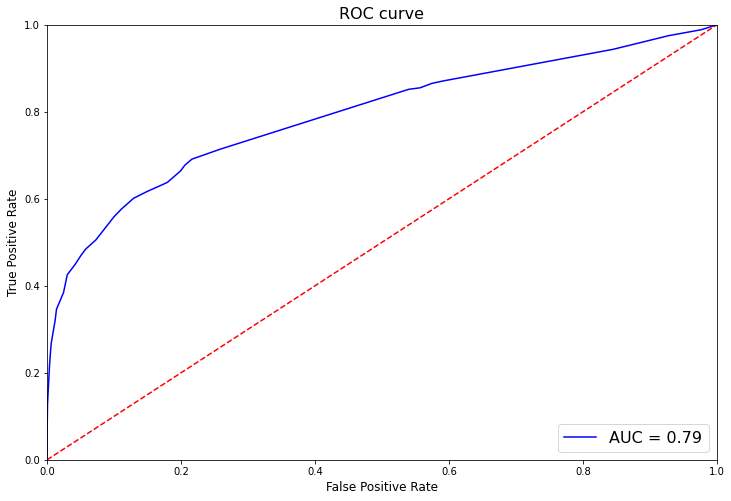

In [113]:
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 8))
plt.title('ROC curve', fontsize=16)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right', fontsize=16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate',fontsize=12)
plt.xlabel('False Positive Rate', fontsize=12)
plt.show()

## CatBoost

In [114]:
catboost = CatBoostClassifier()

In [115]:
catboost_params = {'iterations': range(200,2000,200)}

In [116]:
catboost_grid = GridSearchCV(catboost, catboost_params, n_jobs=-1)

catboost_grid.fit(X_train,y_train)

Learning rate set to 0.021862
0:	learn: 0.6854935	total: 163ms	remaining: 2m 42s
1:	learn: 0.6778122	total: 169ms	remaining: 1m 24s
2:	learn: 0.6703334	total: 174ms	remaining: 57.9s
3:	learn: 0.6633741	total: 177ms	remaining: 44.1s
4:	learn: 0.6560313	total: 180ms	remaining: 35.8s
5:	learn: 0.6507525	total: 183ms	remaining: 30.3s
6:	learn: 0.6445295	total: 186ms	remaining: 26.4s
7:	learn: 0.6383261	total: 189ms	remaining: 23.5s
8:	learn: 0.6335473	total: 192ms	remaining: 21.2s
9:	learn: 0.6296036	total: 195ms	remaining: 19.3s
10:	learn: 0.6256609	total: 198ms	remaining: 17.8s
11:	learn: 0.6222767	total: 201ms	remaining: 16.5s
12:	learn: 0.6175582	total: 204ms	remaining: 15.5s
13:	learn: 0.6134904	total: 208ms	remaining: 14.7s
14:	learn: 0.6091647	total: 211ms	remaining: 13.8s
15:	learn: 0.6050432	total: 214ms	remaining: 13.1s
16:	learn: 0.6019027	total: 217ms	remaining: 12.5s
17:	learn: 0.5992118	total: 220ms	remaining: 12s
18:	learn: 0.5956294	total: 223ms	remaining: 11.5s
19:	learn: 

194:	learn: 0.5011556	total: 796ms	remaining: 3.29s
195:	learn: 0.5010186	total: 800ms	remaining: 3.28s
196:	learn: 0.5009120	total: 804ms	remaining: 3.28s
197:	learn: 0.5007619	total: 807ms	remaining: 3.27s
198:	learn: 0.5006052	total: 810ms	remaining: 3.26s
199:	learn: 0.5005284	total: 814ms	remaining: 3.25s
200:	learn: 0.5004264	total: 817ms	remaining: 3.25s
201:	learn: 0.5002576	total: 820ms	remaining: 3.24s
202:	learn: 0.5000881	total: 824ms	remaining: 3.23s
203:	learn: 0.4999949	total: 827ms	remaining: 3.23s
204:	learn: 0.4998334	total: 830ms	remaining: 3.22s
205:	learn: 0.4996647	total: 833ms	remaining: 3.21s
206:	learn: 0.4995320	total: 837ms	remaining: 3.2s
207:	learn: 0.4994614	total: 840ms	remaining: 3.2s
208:	learn: 0.4993225	total: 843ms	remaining: 3.19s
209:	learn: 0.4991638	total: 847ms	remaining: 3.18s
210:	learn: 0.4990538	total: 850ms	remaining: 3.18s
211:	learn: 0.4989746	total: 853ms	remaining: 3.17s
212:	learn: 0.4988810	total: 856ms	remaining: 3.16s
213:	learn: 0.

373:	learn: 0.4836895	total: 1.4s	remaining: 2.34s
374:	learn: 0.4836583	total: 1.4s	remaining: 2.34s
375:	learn: 0.4835640	total: 1.41s	remaining: 2.34s
376:	learn: 0.4835202	total: 1.41s	remaining: 2.33s
377:	learn: 0.4834004	total: 1.41s	remaining: 2.33s
378:	learn: 0.4832826	total: 1.42s	remaining: 2.32s
379:	learn: 0.4831221	total: 1.42s	remaining: 2.32s
380:	learn: 0.4830023	total: 1.43s	remaining: 2.31s
381:	learn: 0.4829472	total: 1.43s	remaining: 2.31s
382:	learn: 0.4828380	total: 1.43s	remaining: 2.31s
383:	learn: 0.4827968	total: 1.44s	remaining: 2.3s
384:	learn: 0.4827019	total: 1.44s	remaining: 2.3s
385:	learn: 0.4826386	total: 1.44s	remaining: 2.29s
386:	learn: 0.4826380	total: 1.44s	remaining: 2.29s
387:	learn: 0.4825263	total: 1.45s	remaining: 2.28s
388:	learn: 0.4824244	total: 1.45s	remaining: 2.28s
389:	learn: 0.4823772	total: 1.45s	remaining: 2.27s
390:	learn: 0.4823734	total: 1.46s	remaining: 2.27s
391:	learn: 0.4823031	total: 1.46s	remaining: 2.27s
392:	learn: 0.48

555:	learn: 0.4694076	total: 2.02s	remaining: 1.61s
556:	learn: 0.4693566	total: 2.02s	remaining: 1.61s
557:	learn: 0.4692175	total: 2.03s	remaining: 1.6s
558:	learn: 0.4691695	total: 2.03s	remaining: 1.6s
559:	learn: 0.4690735	total: 2.03s	remaining: 1.6s
560:	learn: 0.4690008	total: 2.04s	remaining: 1.59s
561:	learn: 0.4689222	total: 2.04s	remaining: 1.59s
562:	learn: 0.4688374	total: 2.04s	remaining: 1.59s
563:	learn: 0.4687523	total: 2.05s	remaining: 1.58s
564:	learn: 0.4686884	total: 2.05s	remaining: 1.58s
565:	learn: 0.4686160	total: 2.05s	remaining: 1.57s
566:	learn: 0.4685125	total: 2.06s	remaining: 1.57s
567:	learn: 0.4684392	total: 2.06s	remaining: 1.57s
568:	learn: 0.4683747	total: 2.06s	remaining: 1.56s
569:	learn: 0.4683195	total: 2.07s	remaining: 1.56s
570:	learn: 0.4682017	total: 2.07s	remaining: 1.55s
571:	learn: 0.4681967	total: 2.07s	remaining: 1.55s
572:	learn: 0.4681412	total: 2.08s	remaining: 1.55s
573:	learn: 0.4680712	total: 2.08s	remaining: 1.54s
574:	learn: 0.4

739:	learn: 0.4573207	total: 2.62s	remaining: 920ms
740:	learn: 0.4572923	total: 2.62s	remaining: 917ms
741:	learn: 0.4572304	total: 2.63s	remaining: 913ms
742:	learn: 0.4571853	total: 2.63s	remaining: 910ms
743:	learn: 0.4571086	total: 2.63s	remaining: 906ms
744:	learn: 0.4570909	total: 2.64s	remaining: 903ms
745:	learn: 0.4570143	total: 2.64s	remaining: 899ms
746:	learn: 0.4569783	total: 2.64s	remaining: 895ms
747:	learn: 0.4569335	total: 2.65s	remaining: 891ms
748:	learn: 0.4568588	total: 2.65s	remaining: 888ms
749:	learn: 0.4568062	total: 2.65s	remaining: 884ms
750:	learn: 0.4567503	total: 2.65s	remaining: 880ms
751:	learn: 0.4566940	total: 2.66s	remaining: 877ms
752:	learn: 0.4566416	total: 2.66s	remaining: 873ms
753:	learn: 0.4565694	total: 2.67s	remaining: 870ms
754:	learn: 0.4565013	total: 2.67s	remaining: 866ms
755:	learn: 0.4564374	total: 2.67s	remaining: 863ms
756:	learn: 0.4563973	total: 2.67s	remaining: 859ms
757:	learn: 0.4563441	total: 2.68s	remaining: 855ms
758:	learn: 

925:	learn: 0.4473737	total: 3.23s	remaining: 258ms
926:	learn: 0.4473078	total: 3.23s	remaining: 254ms
927:	learn: 0.4472582	total: 3.23s	remaining: 251ms
928:	learn: 0.4472318	total: 3.24s	remaining: 247ms
929:	learn: 0.4472129	total: 3.24s	remaining: 244ms
930:	learn: 0.4471590	total: 3.24s	remaining: 240ms
931:	learn: 0.4471213	total: 3.25s	remaining: 237ms
932:	learn: 0.4470783	total: 3.25s	remaining: 233ms
933:	learn: 0.4470087	total: 3.25s	remaining: 230ms
934:	learn: 0.4469463	total: 3.25s	remaining: 226ms
935:	learn: 0.4468954	total: 3.26s	remaining: 223ms
936:	learn: 0.4468462	total: 3.26s	remaining: 219ms
937:	learn: 0.4467965	total: 3.27s	remaining: 216ms
938:	learn: 0.4467534	total: 3.27s	remaining: 212ms
939:	learn: 0.4466934	total: 3.27s	remaining: 209ms
940:	learn: 0.4466415	total: 3.28s	remaining: 205ms
941:	learn: 0.4466289	total: 3.28s	remaining: 202ms
942:	learn: 0.4465636	total: 3.28s	remaining: 198ms
943:	learn: 0.4465050	total: 3.29s	remaining: 195ms
944:	learn: 

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x0000020C802591E0>,
             n_jobs=-1, param_grid={'iterations': range(200, 2000, 200)})

In [117]:
catboost_grid.best_params_

{'iterations': 1000}

In [118]:
best_catboost = catboost_grid.best_estimator_

In [119]:
y_pred = best_catboost.predict(X_test)

In [120]:
print(f"""CatBoost scores:

Accuracy: {round(accuracy_score(y_test, y_pred), 3)}
Precision: {round(precision_score(y_test, y_pred), 3)}
Recall: {round(recall_score(y_test, y_pred), 3)}
F1 мера: {round(f1_score(y_test, y_pred), 3)}
""")

CatBoost scores:

Accuracy: 0.727
Precision: 0.772
Recall: 0.651
F1 мера: 0.706



In [121]:
probs = best_catboost.predict_proba(X_test)
preds = probs[:,1]

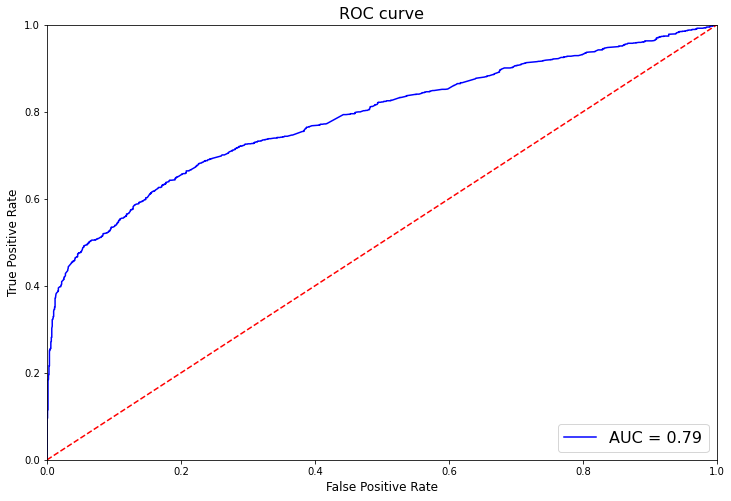

In [122]:
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 8))
plt.title('ROC curve', fontsize=16)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right', fontsize=16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate',fontsize=12)
plt.xlabel('False Positive Rate', fontsize=12)
plt.show()

# Predictions

In [123]:
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

In [124]:
X.shape, y.shape

((8693, 18), (8693,))

In [125]:
catboost_grid.fit(X, y)

Learning rate set to 0.060099
0:	learn: 0.6727888	total: 6.01ms	remaining: 2.4s
1:	learn: 0.6539018	total: 11.7ms	remaining: 2.32s
2:	learn: 0.6376906	total: 16.9ms	remaining: 2.24s
3:	learn: 0.6236598	total: 22.6ms	remaining: 2.24s
4:	learn: 0.6099842	total: 28.1ms	remaining: 2.22s
5:	learn: 0.6003143	total: 33.7ms	remaining: 2.21s
6:	learn: 0.5908387	total: 39.5ms	remaining: 2.22s
7:	learn: 0.5817981	total: 45.4ms	remaining: 2.22s
8:	learn: 0.5758610	total: 49.8ms	remaining: 2.16s
9:	learn: 0.5713889	total: 52.8ms	remaining: 2.06s
10:	learn: 0.5671361	total: 57.5ms	remaining: 2.03s
11:	learn: 0.5637613	total: 61.8ms	remaining: 2s
12:	learn: 0.5585566	total: 67.2ms	remaining: 2s
13:	learn: 0.5548331	total: 72.9ms	remaining: 2.01s
14:	learn: 0.5513090	total: 78.9ms	remaining: 2.02s
15:	learn: 0.5474611	total: 84.3ms	remaining: 2.02s
16:	learn: 0.5448376	total: 89.5ms	remaining: 2.02s
17:	learn: 0.5425963	total: 94.7ms	remaining: 2.01s
18:	learn: 0.5403065	total: 99.9ms	remaining: 2s
19

173:	learn: 0.4885009	total: 778ms	remaining: 1.01s
174:	learn: 0.4883952	total: 783ms	remaining: 1.01s
175:	learn: 0.4881727	total: 787ms	remaining: 1s
176:	learn: 0.4880275	total: 791ms	remaining: 997ms
177:	learn: 0.4878647	total: 795ms	remaining: 991ms
178:	learn: 0.4877610	total: 799ms	remaining: 987ms
179:	learn: 0.4876548	total: 803ms	remaining: 981ms
180:	learn: 0.4875115	total: 807ms	remaining: 976ms
181:	learn: 0.4873462	total: 811ms	remaining: 972ms
182:	learn: 0.4871771	total: 816ms	remaining: 967ms
183:	learn: 0.4869856	total: 820ms	remaining: 963ms
184:	learn: 0.4867272	total: 824ms	remaining: 958ms
185:	learn: 0.4865980	total: 828ms	remaining: 953ms
186:	learn: 0.4865209	total: 832ms	remaining: 948ms
187:	learn: 0.4863246	total: 837ms	remaining: 943ms
188:	learn: 0.4862129	total: 841ms	remaining: 939ms
189:	learn: 0.4862114	total: 844ms	remaining: 932ms
190:	learn: 0.4861032	total: 848ms	remaining: 927ms
191:	learn: 0.4859868	total: 851ms	remaining: 922ms
192:	learn: 0.4

370:	learn: 0.4650526	total: 1.58s	remaining: 123ms
371:	learn: 0.4649807	total: 1.58s	remaining: 119ms
372:	learn: 0.4649001	total: 1.58s	remaining: 115ms
373:	learn: 0.4647883	total: 1.59s	remaining: 110ms
374:	learn: 0.4647883	total: 1.59s	remaining: 106ms
375:	learn: 0.4646871	total: 1.6s	remaining: 102ms
376:	learn: 0.4645457	total: 1.6s	remaining: 97.6ms
377:	learn: 0.4644567	total: 1.6s	remaining: 93.4ms
378:	learn: 0.4643627	total: 1.61s	remaining: 89.2ms
379:	learn: 0.4642126	total: 1.61s	remaining: 84.9ms
380:	learn: 0.4640848	total: 1.62s	remaining: 80.7ms
381:	learn: 0.4640178	total: 1.62s	remaining: 76.4ms
382:	learn: 0.4639195	total: 1.63s	remaining: 72.2ms
383:	learn: 0.4638485	total: 1.63s	remaining: 67.9ms
384:	learn: 0.4637729	total: 1.63s	remaining: 63.6ms
385:	learn: 0.4636499	total: 1.64s	remaining: 59.4ms
386:	learn: 0.4635371	total: 1.64s	remaining: 55.2ms
387:	learn: 0.4634170	total: 1.65s	remaining: 50.9ms
388:	learn: 0.4632913	total: 1.65s	remaining: 46.7ms
38

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x0000020C802591E0>,
             n_jobs=-1, param_grid={'iterations': range(200, 2000, 200)})

In [126]:
best_catboost = catboost_grid.best_estimator_

In [127]:
y_pred = best_catboost.predict(test_df)

In [128]:
df_to_sub = pd.DataFrame({'Transported':y_pred.astype(bool)}, index = test_df.index)

df_to_sub.head()

,Transported
0,True
1,False
2,True
3,True
4,False


In [129]:
df_to_sub.shape, test_df.shape

((4277, 1), (4277, 18))

In [130]:
df_to_sub.to_csv('submission.csv')